# Table of Contents
* [1a. Periodic spinodal decomposition on a square domain](#1a.-Periodic-spinodal-decomposition-on-a-square-domain)
	* [Define $f_0$](#Define-$f_0$)
	* [Define the Equation](#Define-the-Equation)
	* [Solve the Equation](#Solve-the-Equation)
	* [Run the Example Locally](#Run-the-Example-Locally)
	* [Free Energy Plots](#Free-Energy-Plots)

# 2a. Ostwald ripening on a square domain

The chemical free energy is given by

$$ f_{chem}\left[ c, \eta_{1},\dots \eta_{p}\right] = f_0\left[ c, \eta_{1},\dots \eta_{p}) \right] = f^{\alpha}(c)[1-h(\eta_{1}, \dots \eta_{p})]+ f^{\beta}(c)h(\eta_{1}, \dots \eta_{p})+wg(\eta_{1}, \dots \eta_{p})$$

where

$$f^{\alpha}(c) = {\rho}^2(c-c_{\alpha})^2$$
$$f^{\beta}(c) = {\rho}^2(c_{\beta}-c)^2$$
$$h(\eta_{1}, \dots \eta_{p}) = \sum_{i=1}^{p}{ {\eta_{i}}^3(6{\eta_{i}}^2-15\eta_{i}+10)}$$
$$g(\eta_{1}, \dots \eta_{p}) = \sum_{i=1}^{p}{ {\eta_{i}}^2(1-{\eta_{i}})}
=\alpha \sum_{i=1}^{p}\sum_{j{\not=}i}^{p}{{\eta_{i}}^2{\eta_{j}}^2}.$$

The Ginzberg-Landau free energy density is then taken to be

$$ f_0\left[ c, \eta_{1},\dots \eta_{p} \right] + \frac{\kappa_{c}}{2}\left|\nabla c\right|^2 + \sum_{i=1}^{p} \frac{\kappa_{\eta}}{2}\left|\nabla \eta_{i}\right|^2$$

In FiPy we write the evolution equations: 

Cahn-Hilliard
$$ \frac{\partial c}{\partial t} = \nabla \cdot  \left[
       M \left( c \right) \left( \frac{ \partial^2 f_0 }{ \partial c^2} \nabla c - \kappa_{c} \nabla \nabla^2 c \right)   \right] $$

Allen-Cahn
$$ \frac{\partial \eta_{i}}{\partial t} = -L \left[\frac{\delta F}{\delta \eta_{i}}\right]
= -L \left(\frac{\partial f_{0}}{\partial \eta_{i}} - {\kappa}_{\eta} \nabla^2 \eta_{i}\right)$$

## Define the free energy function and take derivatives:

In [33]:
%matplotlib inline
import sympy
import fipy as fp
from fipy import numerix as nmx
import numpy as np
import matplotlib.pyplot as plt
import os

We start by listing parameters of the function.

In [34]:
# parameters which will be given numerical values later
C, rho, Calpha, Cbeta, w, alpha, kappaC, kappai = sympy.symbols("C rho Calpha Cbeta w alpha kappaC kappai")
print C, rho, Calpha, w, alpha, kappaC, kappai

# structural order parameters, etas, which indicate the phase,
# one for each energetically equivalent orientation variant
eta_string = " ".join(['eta_{0}'.format(i) for i in range(2)])
my_etas = sympy.symbols(eta_string)
print my_etas

for i in range(2):
    exec "eta_{0} = 'eta_{0}'".format(i)

C rho Calpha w alpha kappaC kappai
(eta_0, eta_1)


Now we define the full chemical free energy function.

In [35]:
f_a = (rho**2)*(C-Calpha)**2
f_b = (rho**2)*(Cbeta-C)**2

h = []

for etai in my_etas:
    hi = etai**3 * (6*etai**2 - 15*etai +10)
    h.append(hi)

g1 = []
for etai in my_etas:
    g1i = etai**2 * (1 - etai)**2
    g1.append(g1i)

    
g2 = []
for etai in my_etas:
    g2i = []
    for etaj in my_etas:
        if etaj is not etai:
            g2ij = alpha * etai**2 * etaj**2
            g2i.append(g2ij)
        else:
            g2ij = None
    g2 += g2i      

g = g1 + g2

f0 = 0

for hi in h:
    f0 += f_a*(1 - hi) + f_b*hi
for gi in g:
    f0 += w*gi
    
print f0

2*alpha*eta_0**2*eta_1**2*w + eta_0**3*rho**2*(-C + Cbeta)**2*(6*eta_0**2 - 15*eta_0 + 10) + eta_0**2*w*(-eta_0 + 1)**2 + eta_1**3*rho**2*(-C + Cbeta)**2*(6*eta_1**2 - 15*eta_1 + 10) + eta_1**2*w*(-eta_1 + 1)**2 + rho**2*(C - Calpha)**2*(-eta_0**3*(6*eta_0**2 - 15*eta_0 + 10) + 1) + rho**2*(C - Calpha)**2*(-eta_1**3*(6*eta_1**2 - 15*eta_1 + 10) + 1)


Now, we can calculate $ \frac{ \partial^2 f_0 }{ \partial c^2} $ using sympy.

In [36]:
sympy.diff(f0, C, 2)

4*rho**2

Similarly, here is $ \frac{ \partial f_0 }{ \partial {\eta_{i}}} $ for each $\eta_{i}$.

In [37]:
for etai in my_etas:
    print sympy.collect((sympy.diff(f0, etai, 1)), etai)
    print "\n"

eta_0**3*rho**2*(-C + Cbeta)**2*(12*eta_0 - 15) + eta_0**2*(3*rho**2*(-C + Cbeta)**2*(6*eta_0**2 - 15*eta_0 + 10) + w*(2*eta_0 - 2)) + eta_0*(4*alpha*eta_1**2*w + 2*w*(-eta_0 + 1)**2) + rho**2*(C - Calpha)**2*(-eta_0**3*(12*eta_0 - 15) - 3*eta_0**2*(6*eta_0**2 - 15*eta_0 + 10))


eta_1**3*rho**2*(-C + Cbeta)**2*(12*eta_1 - 15) + eta_1**2*(3*rho**2*(-C + Cbeta)**2*(6*eta_1**2 - 15*eta_1 + 10) + w*(2*eta_1 - 2)) + eta_1*(4*alpha*eta_0**2*w + 2*w*(-eta_1 + 1)**2) + rho**2*(C - Calpha)**2*(-eta_1**3*(12*eta_1 - 15) - 3*eta_1**2*(6*eta_1**2 - 15*eta_1 + 10))




These functions will be used later in the solution.

## Define the mesh:

This problem will be run on a square domain with periodic boundary conditions.

In [38]:
N = 200
mesh = fp.PeriodicGrid2D(nx=N, ny=N)

Now, we assign numerical values to the previously listed parameters.

In [62]:
Calpha = fp.Variable(0.3, name=r"$C_\alpha$")
Cbeta = fp.Variable(0.3, name=r"$C_\beta$")
C_0 = fp.Variable(0.5, name=r"$C_0$")
epsilon = fp.Variable(0.05, name=r"$\epsilon$")

M = fp.Variable(5., name=r"$C_\alpha$")
L = fp.Variable(5., name=r"$C_\alpha$")
kappai = fp.Variable(3., name=r"$\kappa_i$")
kappaC = fp.Variable(3., name=r"$\kappa_C$")

rho_s = fp.Variable(nmx.sqrt(2), name=r"$\rho_s$")
w = fp.Variable(1., name=r"$\w$")
alpha = fp.Variable(5., name=r"$\alpha$")
phi = fp.Variable(1.5, name=r"$\phi$")

epsilonij = fp.Variable(0.05, name=r"$\epsilon_{ij}$")
epsilonn = fp.Variable(0.1, name=r"$\epsilon_{n}$")
C = fp.CellVariable(mesh=mesh, name="C", hasOld=True)
eta = [fp.CellVariable(mesh=mesh, name=r"$\eta_{i}$".format(i=i+1), hasOld=True) for i in range(2)]
print eta

[$\eta_1$, $\eta_2$]


While defining the equation with FiPy, recall `f_0` from above calculated using Sympy. We add in gradient energy terms to obtain the complete free energy density.

In [40]:
f = f0 + (kappaC/2.)*(C.grad.mag)**2
for etai in eta:
    f += (kappai/2.)*(etai.grad.mag)**2
f.name = "f"

We now define the equation.

In [44]:
Cf = C.arithmeticFaceValue
Cf.name = "C"
eqC = (fp.TransientTerm(coeff=1., var=C)
       == fp.DiffusionTerm(coeff=M*(4*rho**2), var=C)
       - fp.DiffusionTerm(coeff=(M,kappaC), var=C))
       
# for etai in eta:
#     eqC += fp.DiffusionTerm(coeff=M*(rho)**2 * etai**3 * (6*etai**2 - 15*etai +10) * 2 * (2*Cf-Calpha-Cbeta), var=Cf)
#     eqC += fp.DiffusionTerm(coeff=2*D*gamma*(Cf-Calpha), var=etai)
#    eqC += (fp.ConvectionTerm(coeff=2*D*gamma*etai.faceGrad, var=C) 
#            - (2*D*gamma*Calpha*etai.faceGrad).divergence)

In [49]:
eq_eta = []
for etai in eta:
    eqi = (fp.TransientTerm(coeff=1., var=etai)
           == fp.ImplicitSourceTerm(coeff= L*etai**3*(60*C*Calpha*rho**2 - 60*C*Cbeta*rho**2 - 30*Calpha**2*rho**2 + 30*Cbeta**2*rho**2), var=etai)
           + fp.ImplicitSourceTerm(coeff= L*etai**2*(-120*C*Calpha*rho**2 + 120*C*Cbeta*rho**2 + 60*Calpha**2*rho**2 - 60*Cbeta**2*rho**2 + 4*w), var=etai)
           + fp.ImplicitSourceTerm(coeff= L*etai*(60*C*Calpha*rho**2 - 60*C*Cbeta*rho**2 - 30*Calpha**2*rho**2 + 30*Cbeta**2*rho**2 - 6*w), var = etai)
           + fp.DiffusionTerm(coeff=L*kappai, var=etai))
    for etaj in eta:
        if etaj is not etai:
            eqi += fp.ImplicitSourceTerm(coeff = L*4*alpha*etaj**2*w + 2*w, var=etai)
    eq_eta.append(eqi)

In [50]:
eq = eqC
for eq_etai in eq_eta:
    eq &= eq_etai

In [65]:
x , y = np.array(mesh.x), np.array(mesh.y)

for i, etai in enumerate(eta):
    phase[:] = epsilonn * (np.cos(.01*i*x -4) * np.cos((.007 + .01*i)*y) +\
                    np.cos((.11 + .01*i)*x) * np.cos((.11 + .01*i)*y) +\
                    phi*((np.cos((.046 + .001*i)*x +(.0405 + .0001*i)*y))*(np.cos((.031 + .001*i)*x - (.004 + .001*i)*y)))**2)**2                    
    phase.name = "$\eta$"
    viewer = fp.Viewer(phase)

TypeError: The value of an `_OperatorVariable` cannot be assigned

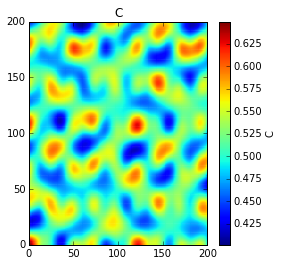

In [57]:

C[:] = C_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + \
                            (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + \
                            + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))

viewer = fp.Viewer(C)

In [61]:
print min(eta[0]), min(eta[0]), eta[0].cellVolumeAverage

0.0 0.0 0.0


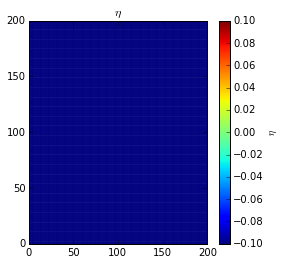

In [53]:
viewer = fp.MatplotlibViewer(vars=phase)

## restart

mesh = fp.dump.read("mesh.dmp")

In [11]:
C = fp.CellVariable(mesh=mesh, name="C", hasOld=True)

In [12]:
eta = [fp.CellVariable(mesh=mesh, name=r"$\eta_{i}$".format(i=i+1), hasOld=True) for i in range(2)]
print eta

[$\eta_1$, $\eta_2$]


In [45]:
f = f0 + (kappaC/2.)*(C.grad.mag)**2
for etai in eta:
    f += (kappai/2.)*(etai.grad.mag)**2
f.name = "f"

In [46]:
Cf = C.arithmeticFaceValue
Cf.name = "C"
eqC = (fp.TransientTerm(coeff=1., var=C)
       == fp.DiffusionTerm(coeff=M*(4*rho**2, var=C)
       - fp.DiffusionTerm(coeff=(D,kappaC), var=C))
# for etai in eta:
#     eqC += fp.DiffusionTerm(coeff=M*(rho)**2 * etai**3 * (6*etai**2 - 15*etai +10) * 2 * (2*Cf-Calpha-Cbeta), var=Cf)
#     eqC += fp.DiffusionTerm(coeff=2*D*gamma*(Cf-Calpha), var=etai)
#    eqC += (fp.ConvectionTerm(coeff=2*D*gamma*etai.faceGrad, var=C) 
#            - (2*D*gamma*Calpha*etai.faceGrad).divergence)

SyntaxError: invalid syntax (<ipython-input-46-456fa114c6a7>, line 4)

In [ ]:
eq_eta = []
for etai in eta:
    eqi = (fp.TransientTerm(coeff=1., var=etai)
           == fp.ImplicitSourceTerm(coeff= etai**3*(60*C*Calpha*rho**2 - 60*C*Cbeta*rho**2 - 30*Calpha**2*rho**2 + 30*Cbeta**2*rho**2), var=etai)
           + fp.ImplicitSourceTerm(coeff= etai**2*(-120*C*Calpha*rho**2 + 120*C*Cbeta*rho**2 + 60*Calpha**2*rho**2 - 60*Cbeta**2*rho**2 + 4*w), var=etai)
           + fp.ImplicitSourceTerm(coeff= etai*(60*C*Calpha*rho**2 - 60*C*Cbeta*rho**2 - 30*Calpha**2*rho**2 + 30*Cbeta**2*rho**2 - 6*w), var = etai)
           + fp.DiffusionTerm(coeff=Li*kappai, var=etai)
    for etaj in eta:
        if etaj is not etai:
            eqi += fp.ImplicitSourceTerm(coeff = 4*alpha*etaj**2*w + 2*w, var=etai)
    eq_eta.append(eqi)


In [ ]:
eq_eta = []
for etai in eta:
    eqi = (fp.TransientTerm(coeff=1., var=etai)
           == fp.ImplicitSourceTerm(coeff=Li*gamma*(C-Calpha)**2, var=etai)
           - fp.ImplicitSourceTerm(coeff=Li*beta*etai**2, var=etai)
           + fp.DiffusionTerm(coeff=Li*kappai, var=etai))
    for etaj in eta:
        if etaj is not etai:
            eqi += fp.ImplicitSourceTerm(coeff=Li*epsilonij*etaj**2, var=etai)
    eq_eta.append(eqi)

## Initialize with noise

In [ ]:
epsilon = 0.01
q = [[0.1*nmx.sqrt(2.)], [0.1*nmx.sqrt(3.)]]
C.value = 0.45 + epsilon * nmx.cos(nmx.dot(q, mesh.cellCenters))

In [ ]:
epsilon = [0.979285, 0.219812, 0.837709, 0.695603, 0.225115, 
           0.389266, 0.585953, 0.614471, 0.918038, 0.518569]

In [ ]:
for i, (etai, epsiloni) in enumerate(zip(eta, epsilon)):
    qi = [[0.01*nmx.sqrt(23 + i + 1)], [0.01*nmx.sqrt(149 + i + 1)]]
    etai.value = 0.01 * epsiloni * nmx.cos(nmx.dot(qi, mesh.cellCenters))**2

## restart

In [ ]:
values = nmx.loadtxt(fname="400.gz", skiprows=1, unpack=True)
x, y = values[0:2]
Cval = values[2]
etaval = values[3:]

In [ ]:
C.value = Cval
for etai, etavali in zip(eta, etaval):
    etai.value = etavali

In [ ]:
fp.MatplotlibViewer(vars=C).plot()

In [ ]:
dt = 0.01
elapsed = 4.0 # 0.
saved = elapsed
duration = 10.
step = 400 # 0

In [ ]:
fp.tools.dump.write(mesh, filename="mesh.dmp")

In [ ]:
fp.TSVViewer(vars=[C] + eta).plot(filename="{step}.gz".format(step=0))

In [ ]:
with open("stats.txt", 'w') as stats:
    stats.write("\t".join(["step", "t", "dt", "Cmin", "Cmax", "f"]) + "\n")

In [ ]:
viewerC = fp.MatplotlibViewer(vars=C)

In [ ]:
eta = [fp.CellVariable(mesh=mesh, name=r"$\eta_{i}$".format(i=i+1), hasOld=True) for i in range(10)]
while elapsed < duration:
    C.updateOld()
    for etai in eta:
        etai.updateOld()
    for sweep in range(2):
#        res = eq.sweep(dt=dt)
        res = [eqC.sweep(C, dt=dt)] #, solver=fp.LinearLUSolver())
        res = res + [eq_etai.sweep(etai, dt=dt) for (eq_etai, etai) in zip(eq_eta, eta)]
        print 'elapsed: ', elapsed
    if max(res) < 0.1:
        step += 1
        elapsed += dt
        dt *= 1.1
        
        viewer.plot()
        if elapsed - saved > 0.1:
            fp.TSVViewer(vars=[C] + eta).plot(filename="{step}.gz".format(step=step))
            viewer.plot()
            saved = elapsed
            
        with open("stats.txt", 'a') as stats:
            stats.write("\t".join([str(it) for it in [step, elapsed, dt, min(C), max(C), 
                                                      f.cellVolumeAverage * mesh.cellVolumes.sum()]]) + "\n")
            
    else:
        dt *= 0.8
        C.value = C.old.value
    print 'dt: ', dt

In [ ]:
etas_sympy = sympy.symbols()

In [20]:
eta_string = " ".join(['eta_{0}'.format(i) for i in range(10)])

In [22]:
my_etas = sympy.symbols(eta_string)

In [ ]:
my_etas[0]

In [23]:
for i in range(10):
    exec "eta_{0} = 'test_{0}'".format(i)

In [24]:
print eta_0

test_0
